In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob # used for folder structure
import seaborn as sns
from PIL import Image # it used to load the images and easy to resize and convert into numpy array


In [35]:
#pip install keras


In [36]:
#pip install tensorflow

In [37]:
#pip install scikit-learn


In [38]:

np.random.seed(42) # results are more predictable/repeatable
from sklearn.metrics import confusion_matrix

import keras
from keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder


In [39]:
skin_df = pd.read_csv('C:/Users/djoshi_Ladmin/Downloads/archive/HAM10000_metadata.csv')

In [40]:
skin_df

lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]

# Handling Missing Values

In [41]:
# Check for missing values in each column
missing_values = skin_df.isnull().sum()

# Print the number of missing values for each column
print("Number of missing values in each column:")
print(missing_values)

# To get a more detailed report on the percentage of missing values
missing_percentage = (skin_df.isnull().sum() / len(skin_df)) * 100
print("\nPercentage of missing values in each column:")
print(missing_percentage)

Number of missing values in each column:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

Percentage of missing values in each column:
lesion_id       0.000000
image_id        0.000000
dx              0.000000
dx_type         0.000000
age             0.569146
sex             0.000000
localization    0.000000
dtype: float64


In [42]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer()
# Select only numeric columns for imputation
numeric_cols = skin_df.select_dtypes(include=np.number).columns.tolist()

numeric_cols

['age']

In [43]:
# Perform imputation on numeric columns only
df_numeric = skin_df[numeric_cols]
df_imputed_numeric = pd.DataFrame(knn_imputer.fit_transform(df_numeric), columns=df_numeric.columns)


# Combine imputed numeric data with non-numeric data
df_non_numeric = skin_df[skin_df.columns.difference(numeric_cols)]
skin_df = pd.concat([df_imputed_numeric, df_non_numeric], axis=1)

# Restore original order of columns, if necessary
skin_df = skin_df[skin_df.columns]

In [46]:
missing_values = skin_df.isnull().sum()
missing_values

age             0
dx              0
dx_type         0
image_id        0
lesion_id       0
localization    0
sex             0
dtype: int64

In [47]:
skin_df = skin_df.drop_duplicates()

# Check the new size of the DataFrame
print(skin_df.shape)

(10015, 7)


# Resizing Images

In [48]:
SIZE=128 # to resize our image into 32X32  (Accuracy could dependent on this we can also try 64X64)

In [49]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [50]:
skin_df['label'] = le.transform(skin_df["dx"]) 


In [51]:
skin_df.head(10)

age   dx dx_type      image_id    lesion_id localization     sex  label
0  80.0  bkl   histo  ISIC_0027419  HAM_0000118        scalp    male      2
1  80.0  bkl   histo  ISIC_0025030  HAM_0000118        scalp    male      2
2  80.0  bkl   histo  ISIC_0026769  HAM_0002730        scalp    male      2
3  80.0  bkl   histo  ISIC_0025661  HAM_0002730        scalp    male      2
4  75.0  bkl   histo  ISIC_0031633  HAM_0001466          ear    male      2
5  75.0  bkl   histo  ISIC_0027850  HAM_0001466          ear    male      2
6  60.0  bkl   histo  ISIC_0029176  HAM_0002761         face    male      2
7  60.0  bkl   histo  ISIC_0029068  HAM_0002761         face    male      2
8  70.0  bkl   histo  ISIC_0025837  HAM_0005132         back  female      2
9  70.0  bkl   histo  ISIC_0025209  HAM_0005132         back  female      2

In [52]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('C:/Users/djoshi_Ladmin/Downloads/archive/', '*', '*.jpg'))}

In [53]:
skin_df['path'] = skin_df['image_id'].map(image_path.get)
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [54]:
skin_df

age     dx dx_type      image_id    lesion_id localization     sex  \
0      80.0    bkl   histo  ISIC_0027419  HAM_0000118        scalp    male   
1      80.0    bkl   histo  ISIC_0025030  HAM_0000118        scalp    male   
2      80.0    bkl   histo  ISIC_0026769  HAM_0002730        scalp    male   
3      80.0    bkl   histo  ISIC_0025661  HAM_0002730        scalp    male   
4      75.0    bkl   histo  ISIC_0031633  HAM_0001466          ear    male   
...     ...    ...     ...           ...          ...          ...     ...   
10010  40.0  akiec   histo  ISIC_0033084  HAM_0002867      abdomen    male   
10011  40.0  akiec   histo  ISIC_0033550  HAM_0002867      abdomen    male   
10012  40.0  akiec   histo  ISIC_0033536  HAM_0002867      abdomen    male   
10013  80.0  akiec   histo  ISIC_0032854  HAM_0000239         face    male   
10014  70.0    mel   histo  ISIC_0032258  HAM_0003521         back  female   

       label                                               path  \
0          2  C:/Users/djoshi_Ladmin/Downloads/archive\HAM10...   
1          2  C:/Users/djoshi_Ladmin/Downloads/archive\HAM10...   
2          2  C:/Users/djoshi_Ladmin/Downloads/archive\HAM10...   
3          2  C:/Users/djoshi_Ladmin/Downloads/archive\HAM10...   
4          2  C:/Users/djoshi_Ladmin/Downloads/archive\HAM10...   
...      ...                                                ...   
10010      0  C:/Users/djoshi_Ladmin/Downloads/archive\HAM10...   
10011      0  C:/Users/djoshi_Ladmin/Downloads/archive\HAM10...   
10012      0  C:/Users/djoshi_Ladmin/Downloads/archive\HAM10...   
10013      0  C:/Users/djoshi_Ladmin/Downloads/archive\HAM10...   
10014      4  C:/Users/djoshi_Ladmin/Downloads/archive\HAM10...   

                                                   image  
0      [[[189, 152, 194], [192, 156, 199], [191, 154,...  
1      [[[24, 13, 22], [24, 14, 22], [25, 14, 26], [2...  
2      [[[187, 127, 135], [190, 134, 146], [193, 136,...  
3      [[[24, 11, 17], [24, 11, 19], [29, 15, 25], [3...  
4      [[[129, 87, 109], [141, 96, 119], [151, 106, 1...  
...                                                  ...  
10010  [[[132, 114, 122], [128, 111, 118], [128, 110,...  
10011  [[[4, 6, 3], [5, 7, 4], [7, 8, 5], [7, 8, 6], ...  
10012  [[[108, 98, 101], [121, 110, 111], [131, 119, ...  
10013  [[[157, 119, 142], [160, 124, 143], [155, 113,...  
10014  [[[179, 148, 132], [178, 146, 138], [177, 141,...  

[10015 rows x 10 columns]

In [55]:
skin_df['path'][0]

'C:/Users/djoshi_Ladmin/Downloads/archive\\HAM10000_images_part_1\\ISIC_0027419.jpg'

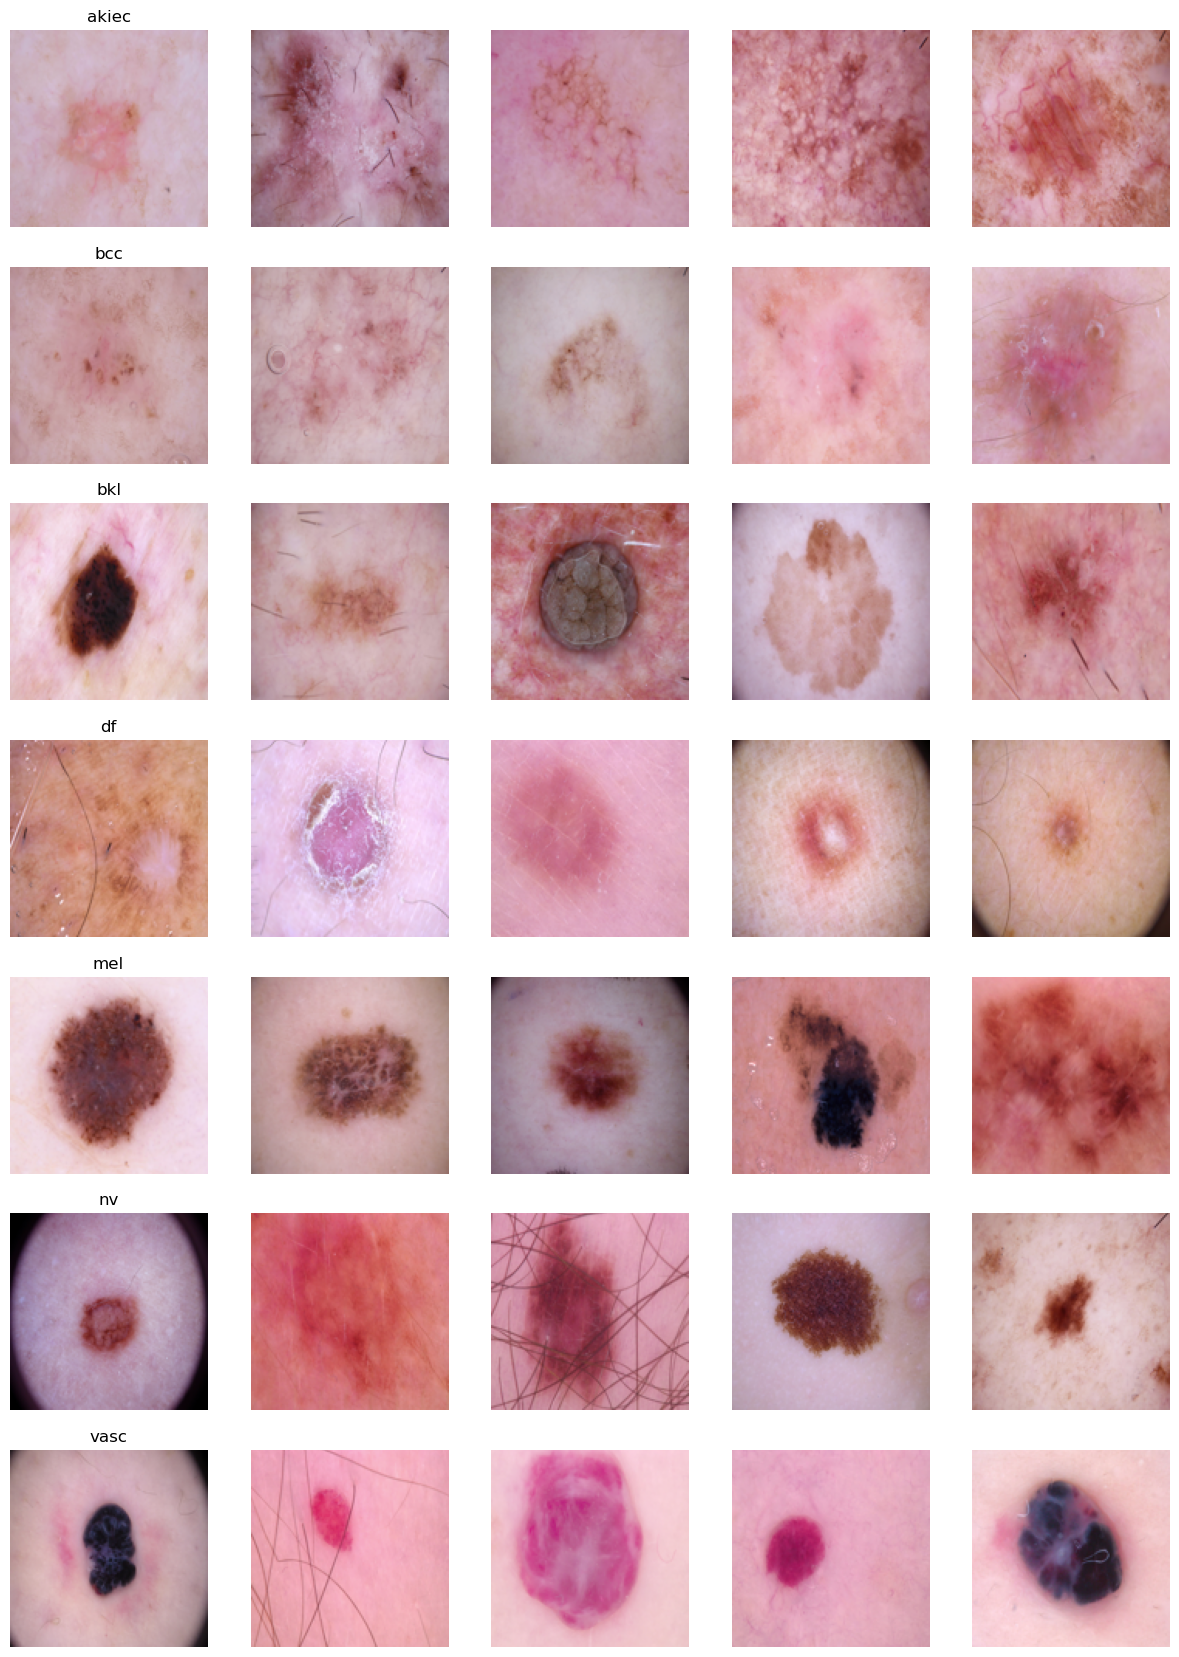

In [56]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (3*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')


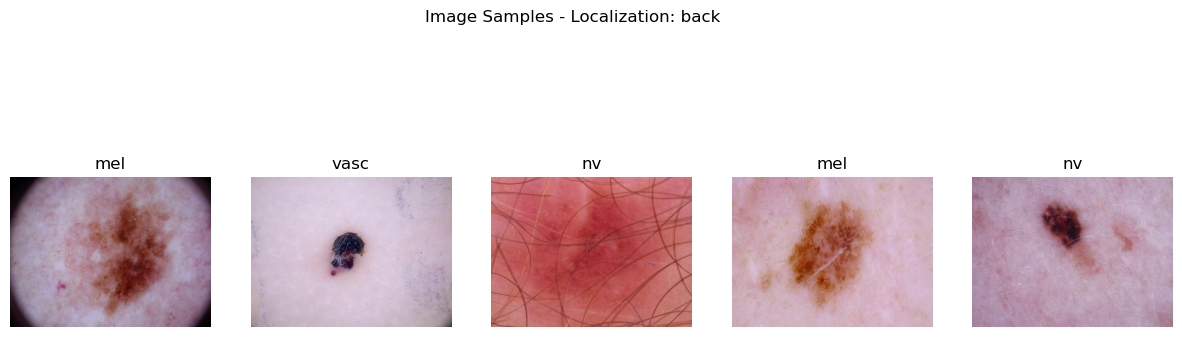

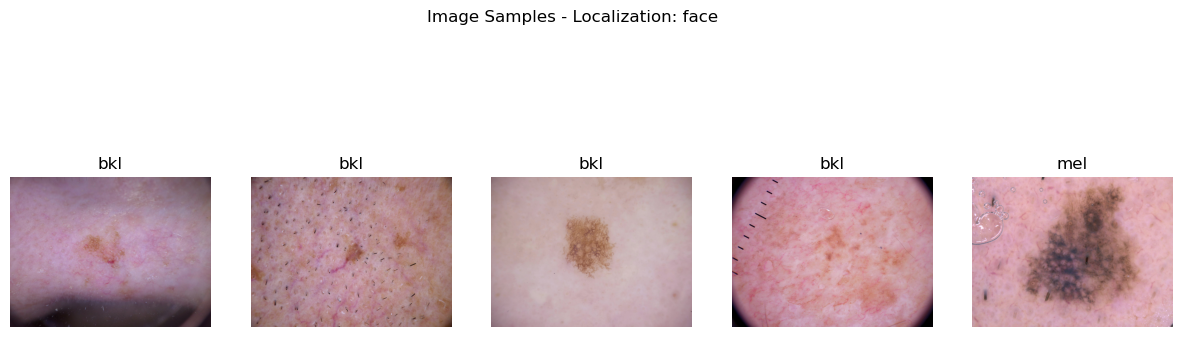

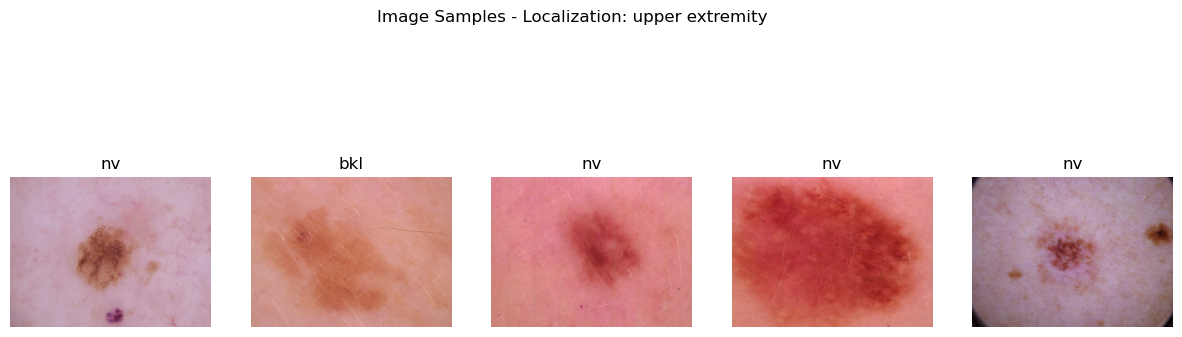

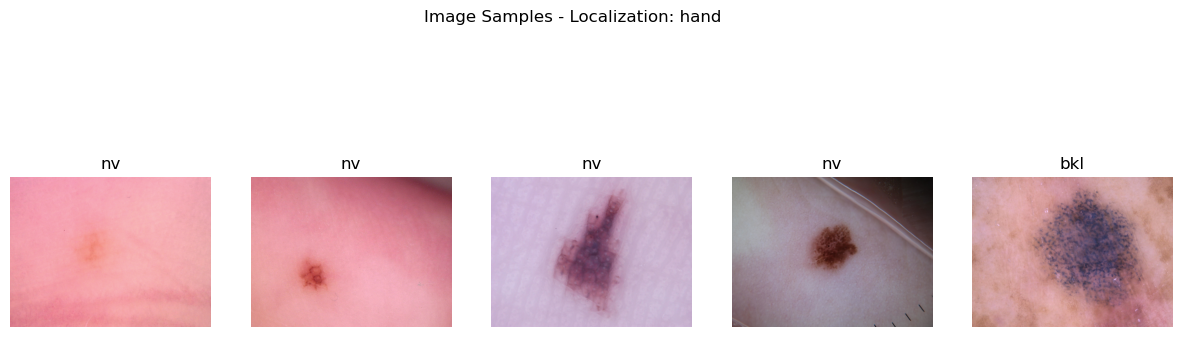

In [57]:
# Assuming each row in the DataFrame has an 'image_path' column with the path to the image file
def display_images_by_localization(df, localization, n_samples=5):
    fig, axs = plt.subplots(1, n_samples, figsize=(15, 5))
    
    sample_df = df[df['localization'] == localization].sample(n_samples, random_state=42)
    
    for i, (_, row) in enumerate(sample_df.iterrows()):
        img = Image.open(row['path'])
        axs[i].imshow(img)
        axs[i].set_title(row['dx'])
        axs[i].axis('off')
    
    plt.suptitle(f'Image Samples - Localization: {localization}')
    plt.show()

# Example usage: Display images for a specific localization
display_images_by_localization(skin_df, 'back')

# Example usage: Display images for a specific localization
display_images_by_localization(skin_df, 'face')

# Example usage: Display images for a specific localization
display_images_by_localization(skin_df, 'upper extremity')

# Example usage: Display images for a specific localization
display_images_by_localization(skin_df, 'hand')

C:\Users\djoshi_Ladmin\AppData\Local\Temp\ipykernel_11848\1722667695.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='orange');
C:\Users\djoshi_Ladmin\Documents\New folder\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


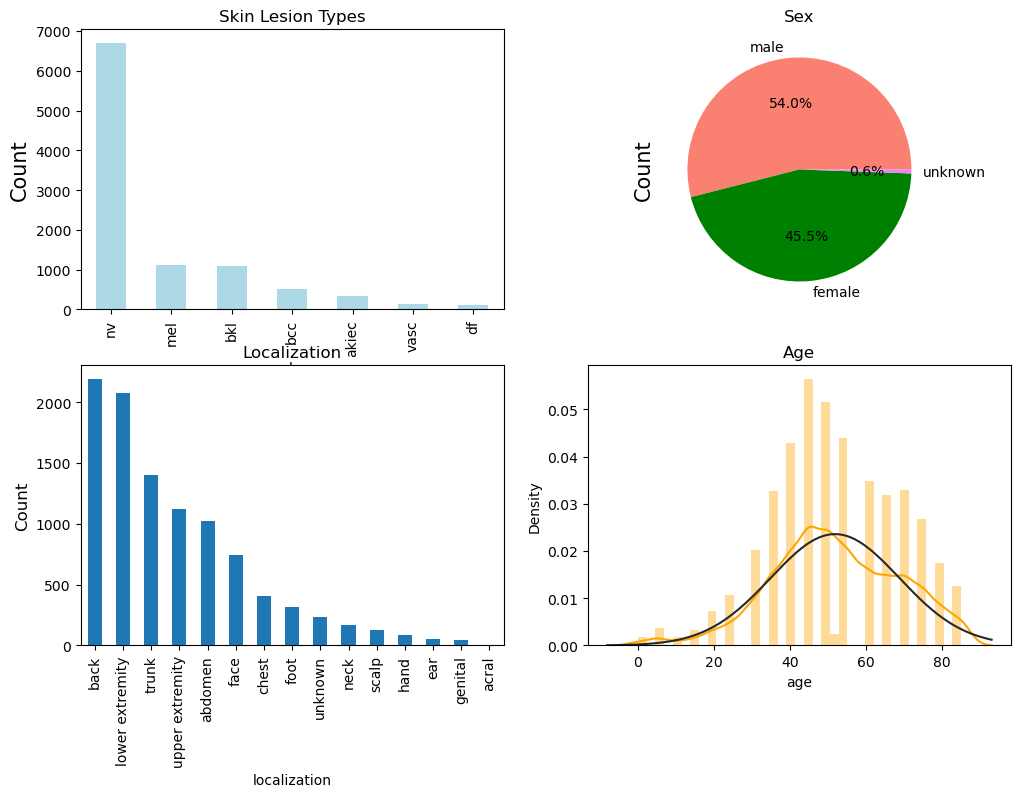

In [58]:
# Data distribution visualization
import matplotlib.pyplot as plt

# Assuming 'fig' is already defined
fig = plt.figure(figsize=(12, 8))

# First subplot
ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1, color='lightblue')  
ax1.set_ylabel('Count', size=15)
ax1.set_title('Skin Lesion Types');

# Second subplot
ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='pie', ax=ax2, colors=['salmon', 'green','violet'], autopct='%1.1f%%')
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

#Third subplot
ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization');

#Fourth subplot
ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='orange');
ax4.set_title('Age')

# Show the plot
plt.show()


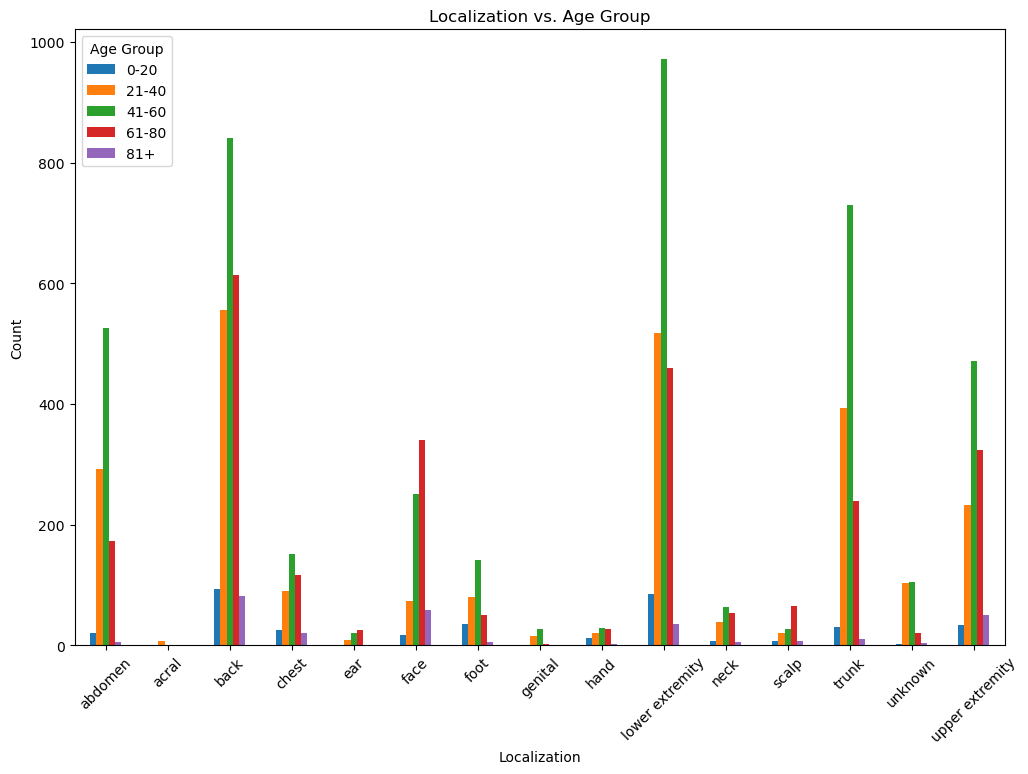

In [59]:
skin_df['age_group'] = pd.cut(skin_df['age'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '21-40', '41-60', '61-80', '81+'])

# Crosstab between localization and age group
loc_vs_age_group = pd.crosstab(skin_df['localization'], skin_df['age_group'])

# Plotting
loc_vs_age_group.plot(kind='bar', figsize=(12, 8))
plt.title('Localization vs. Age Group')
plt.xlabel('Localization')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Age Group',loc='upper left')
plt.show()

# Image Color Normalization

In [60]:
#pip install opencv-python matplotlib

In [61]:
import cv2
from matplotlib import pyplot as plt
from skimage import color, exposure
from PIL import Image

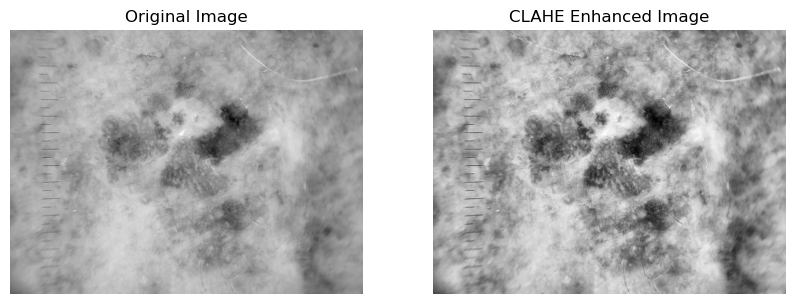

In [62]:
def apply_clahe(image_path, clip_limit=2.0, grid_size=(8, 8)):
     image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
     clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
     clahe_image = clahe.apply(image)
    return clahe_image
image_index = 0
original_image_path = skin_df['path'][image_index]
clahe_image = apply_clahe(original_image_path)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(clahe_image, cmap='gray')
plt.title('CLAHE Enhanced Image')
plt.axis('off')

plt.show()


Contrast Limited Adaptive Histogram Equalization (CLAHE) to images in color (BGR format) using the LAB color space.

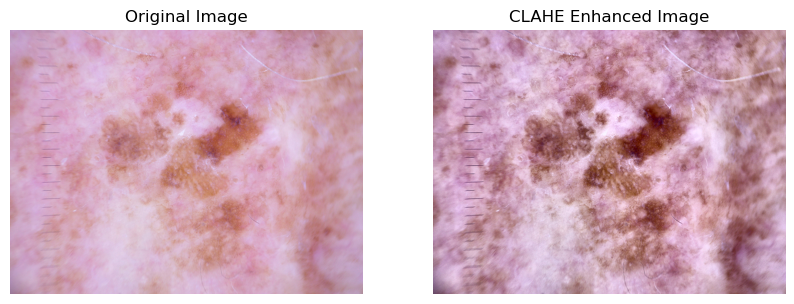

In [64]:

# Function to apply CLAHE to an image
def apply_clahe_color(image_path, clip_limit=2.0, grid_size=(8, 8)):
    # Read image
    image = cv2.imread(image_path)
    
    # Convert image to LAB color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    
    # Split LAB channels
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    
    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    l_channel_clahe = clahe.apply(l_channel)
    
    # Merge LAB channels back
    lab_image_clahe = cv2.merge((l_channel_clahe, a_channel, b_channel))
    
    # Convert LAB image back to BGR color space
    clahe_image = cv2.cvtColor(lab_image_clahe, cv2.COLOR_LAB2BGR)
    
    return clahe_image

# Apply CLAHE to all images in the dataset
clahe_images = []
for image_path in skin_df['path']:
    clahe_image = apply_clahe_color(image_path)
    clahe_images.append(clahe_image)

# Plot the first original and CLAHE-enhanced images side by side for demonstration
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(skin_df['path'][0]), cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(clahe_images[0], cv2.COLOR_BGR2RGB))
plt.title('CLAHE Enhanced Image')
plt.axis('off')

plt.show()


In [74]:
import cv2
import os

def apply_clahe_color(image_path, clip_limit=2.0, grid_size=(8, 8)):
    image = cv2.imread(image_path)
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    l_channel_clahe = clahe.apply(l_channel)
    lab_image_clahe = cv2.merge((l_channel_clahe, a_channel, b_channel))
    clahe_image = cv2.cvtColor(lab_image_clahe, cv2.COLOR_LAB2BGR)
    return clahe_image

# Define the base directory where the images are located
base_dir = r'C:\Users\djoshi_Ladmin\Downloads\archive'

# Define subdirectories containing the images
image_dirs = ['HAM10000_images_part_1', 'HAM10000_images_part_2']

# Define the directory where normalized images will be saved
normalized_images_dir = os.path.join(base_dir, 'color_normalized_dataset')

# Create the directory for normalized images if it doesn't exist
if not os.path.exists(normalized_images_dir):
    os.makedirs(normalized_images_dir)

# Process images in each subdirectory
for sub_dir in image_dirs:
    full_dir_path = os.path.join(base_dir, sub_dir)
    for filename in os.listdir(full_dir_path):
        if filename.lower().endswith(('.jpg', '.png')):
            image_path = os.path.join(full_dir_path, filename)
            normalized_image = apply_clahe_color(image_path)
            save_path = os.path.join(normalized_images_dir, filename)
            cv2.imwrite(save_path, normalized_image)

print("Normalization complete. Normalized images saved in:", normalized_images_dir)


Normalization complete. Normalized images saved in: C:\Users\djoshi_Ladmin\Downloads\archive\color_normalized_dataset


# Data Augmentation

In [79]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

main_dir = r'C:\Users\djoshi_Ladmin\Downloads\archive\color_normalized_dataset'
augmented_dir = r'C:\Users\djoshi_Ladmin\Downloads\archive\augmented_data'
if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')
for filename in os.listdir(main_dir):
    if filename.lower().endswith(('.jpg', '.jpeg')):  # Supports both .jpg and .jpeg (case insensitive)
        img_path = os.path.join(main_dir, filename)
        img = load_img(img_path)  
        x = img_to_array(img)  
        x = x.reshape((1,) + x.shape)
        original_name = os.path.splitext(filename)[0]
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=augmented_dir, 
                                  save_prefix=f'{original_name}', save_format='jpg'):
            i += 1
            if i >= 5:
                break

print("Data augmentation is complete. Augmented images are saved in:", augmented_dir)


Data augmentation is complete. Augmented images are saved in: C:\Users\djoshi_Ladmin\Downloads\archive\augmented_data


# Data Segmentation

In [83]:
import os
import shutil
from sklearn.model_selection import train_test_split
augmented_data_dir = r'C:\Users\djoshi_Ladmin\Downloads\archive\augmented_data'
base_dir = r'C:\Users\djoshi_Ladmin\Downloads\archive'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')
def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


In [84]:
create_dir(train_dir)
create_dir(val_dir)
create_dir(test_dir)
files = [f for f in os.listdir(augmented_data_dir) if os.path.isfile(os.path.join(augmented_data_dir, f))]
train_files, test_files = train_test_split(files, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)
def copy_files(source_files, target_dir):
    for file in source_files:
        shutil.copy(os.path.join(augmented_data_dir, file), os.path.join(target_dir, file))
copy_files(train_files, train_dir)
copy_files(val_files, val_dir)
copy_files(test_files, test_dir)

print(f"Data segmentation complete. Files distributed as follows: \nTrain: {len(train_files)} \nValidation: {len(val_files)} \nTest: {len(test_files)}")


Data segmentation complete. Files distributed as follows: 
Train: 35046 
Validation: 7510 
Test: 7510


In [101]:
# Define your base directories
base_dir = r'C:\Users\djoshi_Ladmin\Downloads\archive'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create subdirectories for classes in each of the train, val, and test directories
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
for class_name in classes:
    for dir in [train_dir, val_dir, test_dir]:
        class_dir = os.path.join(dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

In [102]:
# Function to move images to their respective class-named directories
def move_images_to_class_dirs(src_dir, df):
    for _, row in df.iterrows():
        # Construct the original file name
        file_name = row['image_id'] + '.jpg'
        # Construct the destination path
        class_subdir = os.path.join(src_dir, row['dx'])
        dest_path = os.path.join(class_subdir, file_name)
        
        # Find all files that match the 'image_id' pattern
        for img_file in os.listdir(src_dir):
            if img_file.startswith(row['image_id']) and img_file.endswith('.jpg'):
                # Move the file
                src_path = os.path.join(src_dir, img_file)
                shutil.move(src_path, dest_path)
                break  # Assuming there's only one match, we break out of the loop

# Move images in the 'train' directory
move_images_to_class_dirs(train_dir, skin_df)
move_images_to_class_dirs(val_dir, skin_df)
move_images_to_class_dirs(test_dir, skin_df)

# CNN

In [116]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam


model = Sequential([
    # Convolutional base
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Flattening the output and feeding it into a dense layer
    Flatten(),
    Dense(512, activation='relu'),
    
    # Output layer
    Dense(7, activation='softmax')  # Assuming 7 classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary to verify architecture
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,456,199 (13.18 MB)

 Trainable params: 3,456,199 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

In [108]:
# Take a single batch of images and labels from the training generator
x_batch, y_batch = next(train_generator)

# Check the shape of the batch
print(f"Batch shape: {x_batch.shape}")
print(f"Labels shape: {y_batch.shape}")


Batch shape: (32, 150, 150, 3)
Labels shape: (32, 7)


In [117]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
base_dir = r'C:\Users\djoshi_Ladmin\Downloads\archive'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Define ImageDataGenerators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Flow validation images in batches using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 9696 images belonging to 7 classes.
Found 5585 images belonging to 7 classes.


In [119]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Epoch 1/25
303/303 ━━━━━━━━━━━━━━━━━━━━ 157s 513ms/step - accuracy: 0.6799 - loss: 0.9767 - val_accuracy: 0.6773 - val_loss: 0.9066
Epoch 2/25


C:\Users\djoshi_Ladmin\Documents\New folder\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5882 - val_loss: 0.4854
Epoch 3/25
303/303 ━━━━━━━━━━━━━━━━━━━━ 134s 436ms/step - accuracy: 0.6819 - loss: 0.8840 - val_accuracy: 0.6877 - val_loss: 0.8777
Epoch 4/25
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7647 - val_loss: 0.3487
Epoch 5/25
303/303 ━━━━━━━━━━━━━━━━━━━━ 130s 424ms/step - accuracy: 0.7007 - loss: 0.8468 - val_accuracy: 0.6950 - val_loss: 0.8094
Epoch 6/25
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7059 - val_loss: 0.3261
Epoch 7/25
303/303 ━━━━━━━━━━━━━━━━━━━━ 130s 423ms/step - accuracy: 0.7031 - loss: 0.8151 - val_accuracy: 0.7144 - val_loss: 0.7696
Epoch 8/25
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7059 - val_loss: 0.3737
Epoch 9/25
303/303 ━━━━━━━━━━━━━━━━━━━━ 133s 434ms/step - accur

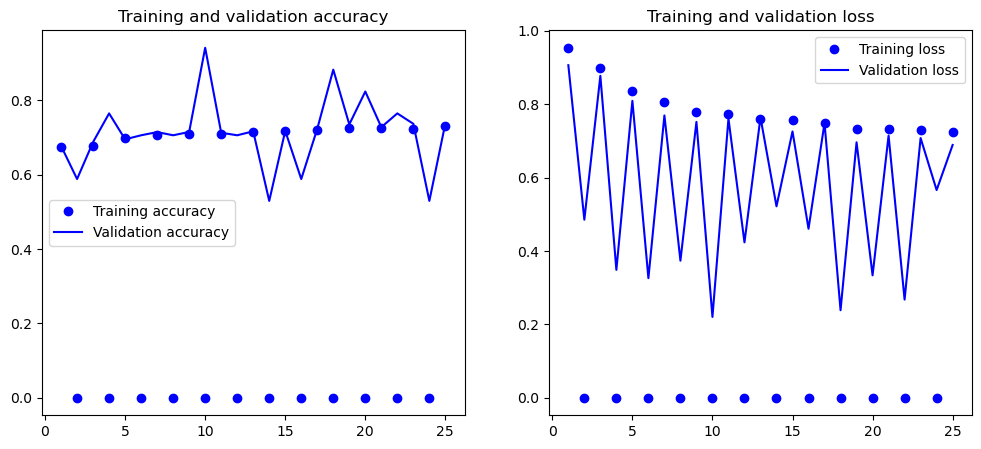

In [125]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [127]:
model.save('path_to_save_your_model/my_model.h5')


# OVA

In [130]:
# Define image dimensions and other parameters
image_width, image_height = 150, 150
batch_size = 32
num_channels = 3  # Assuming RGB images

# Define ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and testing data from directories
train_generator = train_datagen.flow_from_directory(
    r'C:\Users\djoshi_Ladmin\Downloads\archive\train',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical'  # Assuming you have multiple classes
)

test_generator = test_datagen.flow_from_directory(
    r'C:\Users\djoshi_Ladmin\Downloads\archive\test',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 9696 images belonging to 7 classes.
Found 5564 images belonging to 7 classes.


In [131]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')  # Adjust output layer for multi-class classification
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [132]:
def train_ova_models(train_generator, classes):
    ova_models = {}
    input_shape = (image_width, image_height, num_channels)
    num_classes = len(classes)
    for class_name in classes:
        model = create_cnn_model(input_shape, num_classes)
        # Prepare binary labels for the current class
        binary_labels = np.zeros((train_generator.samples, num_classes))
        binary_labels[:, train_generator.class_indices[class_name]] = 1
        # Train the binary classifier
        model.fit(train_generator, epochs=10, validation_data=test_generator)
        ova_models[class_name] = model
    return ova_models

In [133]:
def evaluate_ova_models(test_generator, ova_models):
    evaluation_scores = {}
    for class_name, model in ova_models.items():
        loss, accuracy = model.evaluate(test_generator)
        evaluation_scores[class_name] = accuracy
    return evaluation_scores

# Get the list of classes from the train_generator
classes = list(train_generator.class_indices.keys())

# Train the OVA models
ova_models = train_ova_models(train_generator, classes)

# Evaluate the OVA models
evaluation_scores = evaluate_ova_models(test_generator, ova_models)

print("Evaluation Scores:", evaluation_scores)

Epoch 1/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 168s 542ms/step - accuracy: 0.6478 - loss: 1.1489 - val_accuracy: 0.6695 - val_loss: 0.9117
Epoch 2/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 131s 427ms/step - accuracy: 0.6708 - loss: 0.9125 - val_accuracy: 0.6628 - val_loss: 0.9114
Epoch 3/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 136s 444ms/step - accuracy: 0.6804 - loss: 0.8667 - val_accuracy: 0.6997 - val_loss: 0.7898
Epoch 4/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 139s 454ms/step - accuracy: 0.7076 - loss: 0.7844 - val_accuracy: 0.7184 - val_loss: 0.8175
Epoch 5/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 131s 426ms/step - accuracy: 0.7155 - loss: 0.7663 - val_accuracy: 0.7283 - val_loss: 0.7339
Epoch 6/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 130s 423ms/step - accuracy: 0.7220 - loss: 0.7433 - val_accuracy: 0.7293 - val_loss: 0.7171
Epoch 7/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 135s 441ms/step - accuracy: 0.7408 - loss: 0.6922 - val_accuracy: 0.7212 - val_loss: 0.7460
Epoch 8/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 131s 425ms/step - accuracy: 0.7518 -

In the provided code snippet, the number of epochs for training each binary classifier in the OVA (One-Versus-All) strategy is set to epochs=10 in the model.fit() function call. This means that each binary classifier will be trained for 10 epochs on the training data.

So, if you have 
�
N classes in your dataset, the total number of epochs for training all OVA models would be 
�
×
10
N×10, as each class is trained independently.

For example, if you have 7 classes in your dataset, each OVA model will be trained for 10 epochs, resulting in a total of 
7
×
10
=
70
7×10=70 epochs for training all OVA models.